Train Shape: (15000, 20)
Test Shape: (10000, 19)

================ EDA & VISUALIZATION ================

Null Values per Column:
id                  0
N_Days              0
Drug             6541
Age                 0
Sex                 0
Ascites          6540
Hepatomegaly     6543
Spiders          6552
Edema               0
Bilirubin           0
Cholesterol      8375
Albumin             0
Copper           6657
Alk_Phos         6547
SGOT             6551
Tryglicerides    8422
Platelets         582
Prothrombin        19
Stage               0
Status              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8459 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 

/tmp/ipython-input-3333171535.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train["Status"], palette="viridis")


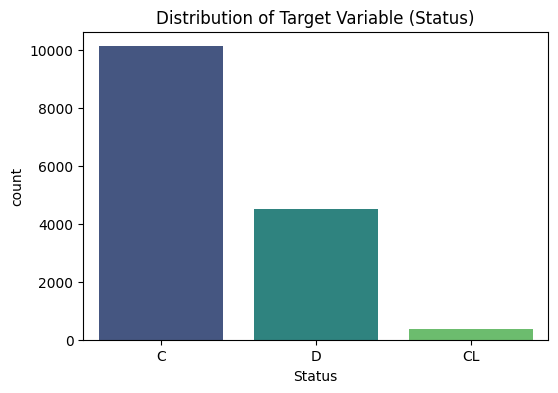

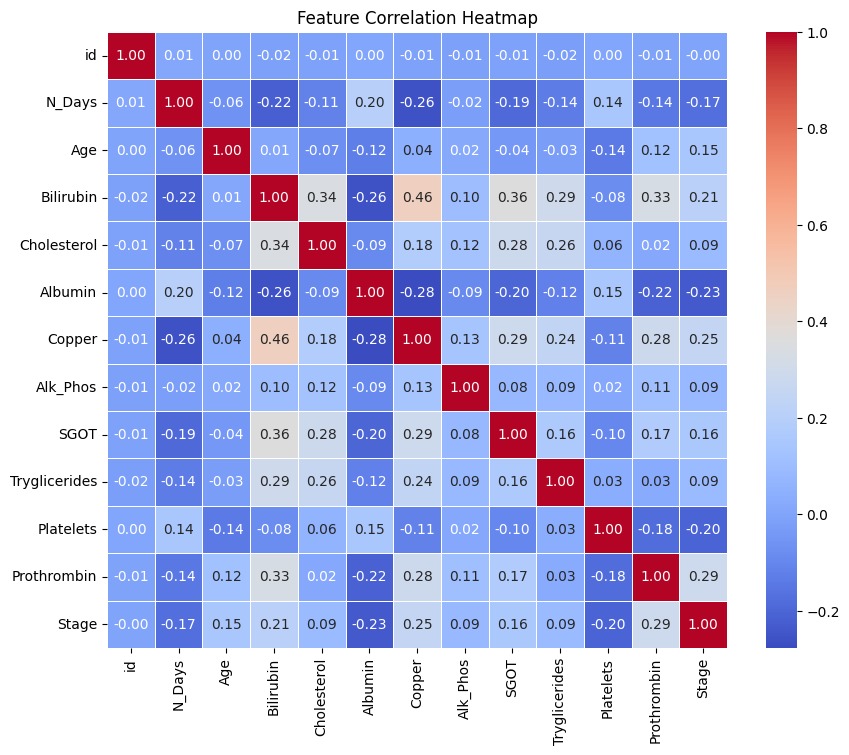

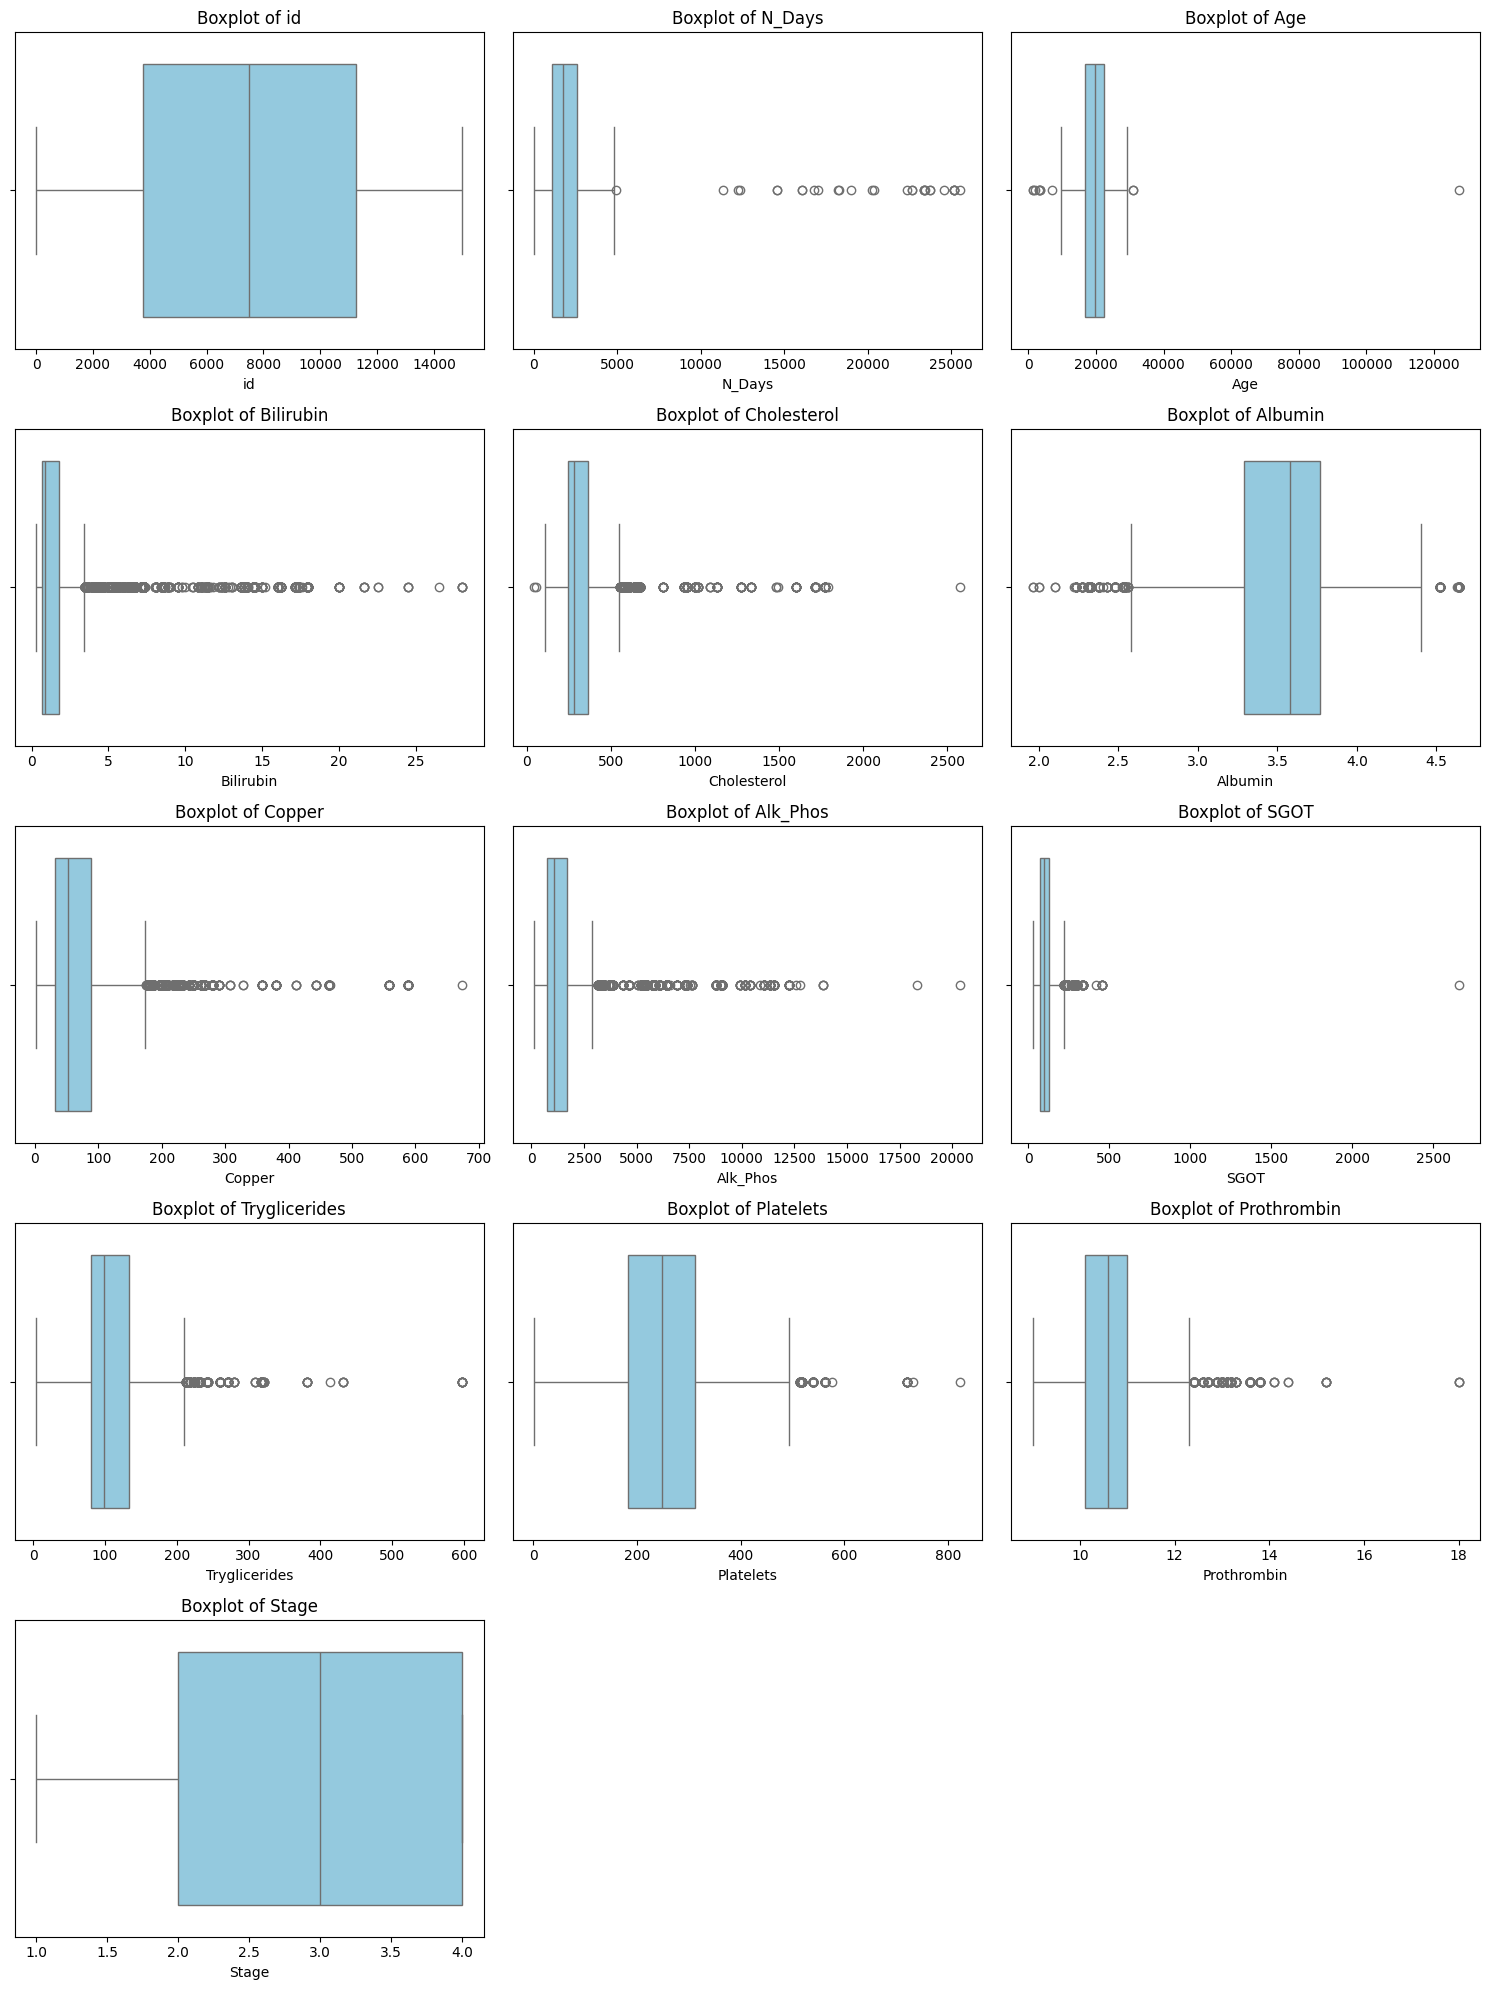


================ DATA CLEANING ================
Rows dropped: 8702
Remaining Training Rows: 6298

================ OUTLIER REMOVAL ================
Rows removed by IsolationForest: 189
IQR Capping complete!

================ MODEL TRAINING ================
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/tmp/ipython-input-3333171535.py:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(cat_col, group_keys=False, observed=True, sort=False).apply(cap_group)



🔎 Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

================ VALIDATION METRICS ================
Accuracy : 0.8608837970540099
Classification Report:
               precision    recall  f1-score   support

           C       0.88      0.95      0.91       847
          CL       1.00      0.03      0.05        37
           D       0.81      0.74      0.77       338

    accuracy                           0.86      1222
   macro avg       0.90      0.57      0.58      1222
weighted avg       0.86      0.86      0.85      1222


Confusion Matrix:


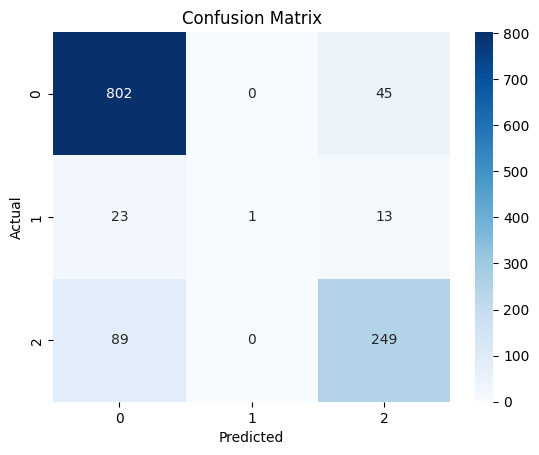


📁 Submission saved to submission.csv


In [ ]:
# =====================================================================
# 📌 COMPLETE PIPELINE WITH EDA + OUTLIER ANALYSIS + RANDOM FOREST
# =====================================================================

# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss, confusion_matrix,
    classification_report
)
from sklearn.pipeline import Pipeline

# =====================================================================
# 2️⃣ Load Data
# =====================================================================
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)


# =====================================================================
# 🎨 3️⃣ PERFORM EDA (Exploratory Data Analysis)
# =====================================================================
print("\n================ EDA & VISUALIZATION ================")

# --- A. Check for Nulls ---
print("\nNull Values per Column:")
print(train.isnull().sum())
train.info()
train.head()
# train.drop(['id','CustomerId','Surname'],axis=1,inplace=True)
train.head()
train.isnull().sum()
train.duplicated().sum()
train.nunique()

# --- B. Target Variable Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x=train["Status"], palette="viridis")
plt.title("Distribution of Target Variable (Status)")
plt.show()

# --- C. Correlation Heatmap ---
# Select only numeric columns for correlation
numeric_df = train.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- D. Box Plots (Outlier Visualization) ---
# We loop through numeric columns to visualize distributions
cols_to_plot = numeric_df.columns
# Calculate grid size for subplots
n_cols = 3
n_rows = (len(cols_to_plot) - 1) // n_cols + 1

plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=train[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


# =====================================================================
# 4️⃣ Data Cleaning: Drop Nulls (As Requested)
# =====================================================================
print("\n================ DATA CLEANING ================")
initial_rows = len(train)

# Drop rows with ANY missing values in the training set
train.dropna(inplace=True)

print(f"Rows dropped: {initial_rows - len(train)}")
print(f"Remaining Training Rows: {len(train)}")

# NOTE: We CANNOT drop rows from Test data (we must submit all rows).
# We will fill Test nulls with Mean/Mode later to prevent errors.


# =====================================================================
# 5️⃣ Split Target + Features
# =====================================================================
y = train["Status"]
X = train.drop(columns=["Status"])

# Safety Fill for TEST data only (Since we can't drop test rows)
for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].fillna(test[col].mode()[0])
    else:
        test[col] = test[col].fillna(test[col].mean())


# =====================================================================
# 6️⃣ Outlier Analysis (Isolation Forest + IQR)
# =====================================================================
print("\n================ OUTLIER REMOVAL ================")

# Identify numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# ------------------------- (A) Isolation Forest ------------------------
iso = IsolationForest(contamination=0.03, random_state=42)
outlier_flags = iso.fit_predict(X[numeric_cols])

# -1 = outlier, 1 = normal
X_clean = X[outlier_flags == 1]
y_clean = y[outlier_flags == 1]

print(f"Rows removed by IsolationForest: {len(X) - len(X_clean)}")

# ------------------------- (B) IQR Outlier Capping ----------------------
def cap_outliers_categorywise_all(df, cat_col, num_cols):
    def cap_group(group):
        group = group.copy()
        for col in num_cols:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            group[col] = group[col].clip(lower, upper)
        return group
    return df.groupby(cat_col, group_keys=False, observed=True, sort=False).apply(cap_group)

# Find a categorical column to group by (or skip if none exist)
if len(X_clean.select_dtypes(include="object").columns) > 0:
    categorical_col_for_capping = "Region" if "Region" in X_clean.columns else X_clean.select_dtypes(include="object").columns[0]

    # Combine X and y temporarily for the groupby operation
    temp_df = X_clean.copy()
    temp_df["Status"] = y_clean

    X_capped_full = cap_outliers_categorywise_all(temp_df, categorical_col_for_capping, numeric_cols)

    y_clean = X_capped_full["Status"]
    X_clean = X_capped_full.drop(columns=["Status"])
    print("IQR Capping complete!")
else:
    print("No categorical column found for IQR grouping. Skipping IQR step.")


# =====================================================================
# 7️⃣ Train–Validation Split
# =====================================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)


# =====================================================================
# 8️⃣ Preprocessing Pipeline setup
# =====================================================================
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

base_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


# =====================================================================
# 9️⃣ Hyperparameter Tuning
# =====================================================================
print("\n================ MODEL TRAINING ================")
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
}

grid = GridSearchCV(
    base_model,
    param_grid,
    scoring="accuracy",  # Changed to accuracy (safer if log_loss fails on some metrics)
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\n🔎 Best Parameters:", grid.best_params_)


# =====================================================================
# 🔟 Validation Results
# =====================================================================
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)

print("\n================ VALIDATION METRICS ================")
print("Accuracy :", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


# =====================================================================
# 1️⃣1️⃣ Submission Generation
# =====================================================================
test_processed = test[X.columns]
predict_proba = best_model.predict_proba(test_processed)
class_labels = list(best_model.classes_)

submission = pd.DataFrame({"id": test["id"]})
for i, cls in enumerate(class_labels):
    submission[f"Status_{cls}"] = predict_proba[:, i]

submission.to_csv("submission.csv", index=False)
print("\n📁 Submission saved to submission.csv")